In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
from binance.client import Client
from binance import enums
api_key = 'your key'
api_secret = 'your secret'
client = Client(api_key, api_secret)

In [3]:
symbols = [
    'BTC/USDT',
    'XRP/USDT', 
    'ETH/USDT', 
    'ADA/USDT', 
    'XLM/USDT', 
    'XVG/USDT', 
    'LTC/USDT', 
    'IOTA/USDT', 
    'QTUM/USDT', 
    'NEO/USDT', 
    'DASH/USDT', 
    'ETC/USDT', 
    'LSK/USDT', 
    'XMR/USDT', 
    'OMG/USDT', 
    'STRAT/USDT', 
    'ZEC/USDT',
    'BCC/USDT'
]

In [4]:
import cryptoz
from cryptoz import stats, utils
from cryptoz.data import binance

ohlc = binance.chartdata(client, symbols, interval=enums.KLINE_INTERVAL_30MINUTE)

In [5]:
orderbooks = binance.orderbooks(client, symbols)

# basics

## klines

    count         mean          std       min       25%       50%         75%  \
0  1152.0  1103.416555  3241.263079  0.119567  3.668308  39.51334  520.552028   

       max  
0  16055.0  


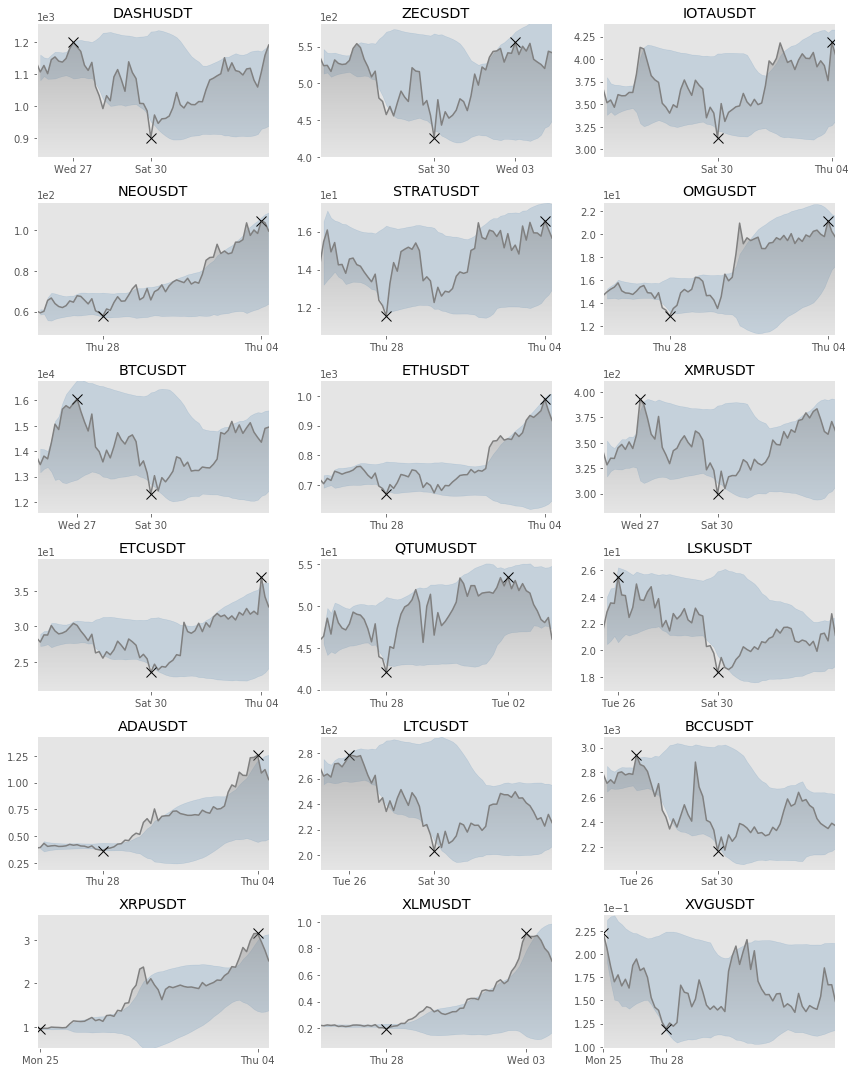

In [6]:
df = utils.to_df(ohlc, 'C').resample('4H').last()
sma = df.rolling(30, min_periods=1).mean()
sms = df.rolling(30, min_periods=1).std()
bands = (sma + 2 * sms, sma - 2 * sms)
ranker = lambda sr: 1 - sr.iloc[-1] / sr.max()

cryptoz.plot.timesr_matrix(df, bands=bands, ranker=ranker)

## pctchange

   count      mean       std       min       25%       50%      75%       max
0  846.0 -0.000269  0.022554 -0.091649 -0.010554 -0.000965  0.00884  0.198314


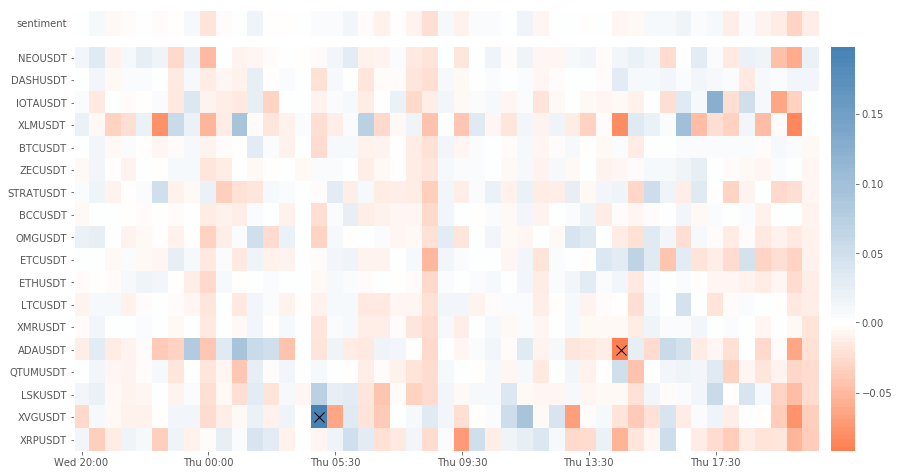

In [24]:
df = utils.to_df(ohlc, 'C').iloc[-48:]

ranker = lambda sr: -sr[-1]
cmap = cryptoz.plot.continuous_cmap(['coral', 'white', 'steelblue'])
norm = cryptoz.plot.midpoint_norm(0)
cryptoz.plot.evolution(df.pct_change().dropna(), ranker=ranker, cmap=cmap, norm=norm)

## hist

    count      mean      std       min       25%       50%       75%       max
0  9000.0  0.000677  0.02105 -0.180914 -0.008828  0.000787  0.009754  0.220623


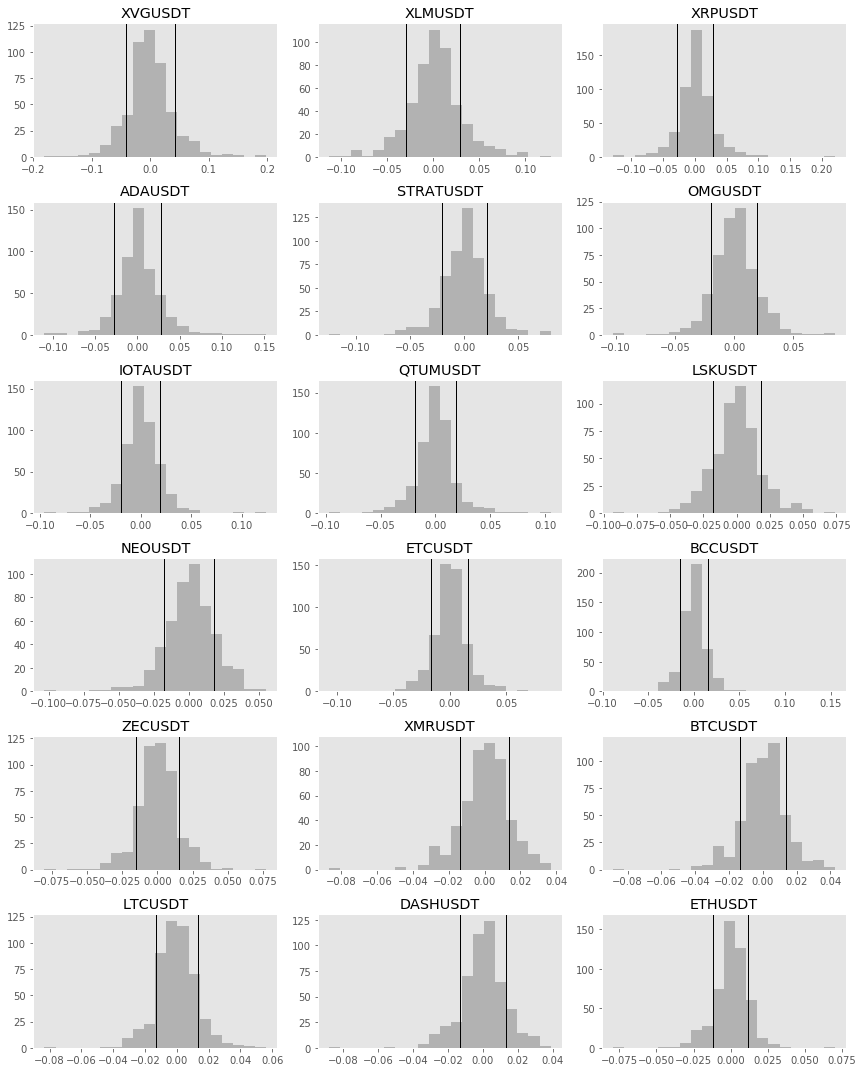

In [8]:
df = utils.to_df(ohlc, 'C').pct_change().fillna(0)
ranker = lambda sr: 1 / sr.std()
axvlines = [lambda sr: -sr.std(), lambda sr: sr.std()]
cryptoz.plot.hist_matrix(df, axvlines=axvlines, ranker=ranker)

# drawdown

   count      mean       std      min       25%       50%       75%       max
0  864.0  0.150078  0.082396  0.01066  0.097829  0.133912  0.191724  0.454471


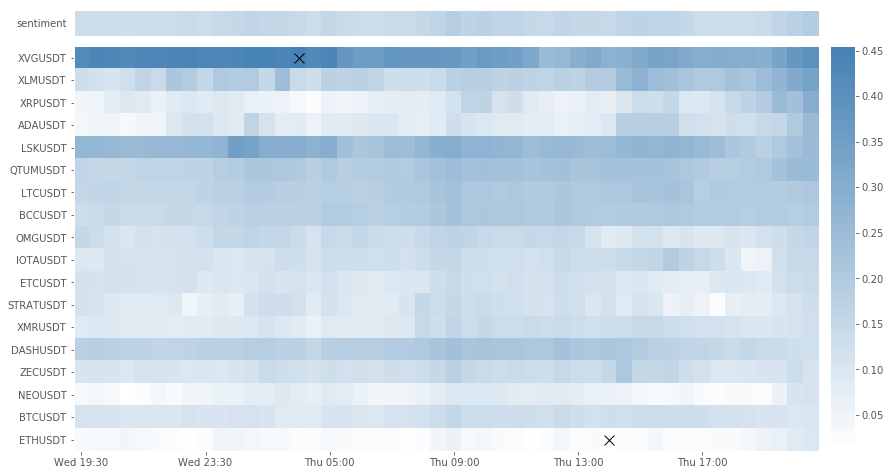

In [22]:
df = stats.dd.from_ohlc(ohlc).iloc[-48:]

ranker = lambda sr: -sr.iloc[-1]
cmap = cryptoz.plot.continuous_cmap(['white', 'steelblue'])
cryptoz.plot.evolution(df, ranker=ranker, cmap=cmap)

## current

In [10]:
stats.dd.now(ohlc)

NEOUSDT      0.086159
ETHUSDT      0.091827
BTCUSDT      0.094136
ZECUSDT      0.097760
DASHUSDT     0.099895
STRATUSDT    0.107158
XMRUSDT      0.118454
IOTAUSDT     0.124116
ETCUSDT      0.135387
OMGUSDT      0.136964
BCCUSDT      0.193261
LTCUSDT      0.206795
ADAUSDT      0.214184
LSKUSDT      0.240902
QTUMUSDT     0.246987
XRPUSDT      0.248483
XLMUSDT      0.307186
XVGUSDT      0.388705
dtype: float64

## max duration

In [11]:
stats.dd.max_duration(ohlc)

ADAUSDT     00:00:00
XLMUSDT     00:00:00
STRATUSDT   00:00:00
NEOUSDT     00:00:00
XVGUSDT     00:00:00
LSKUSDT     00:00:00
ZECUSDT     00:00:00
ETHUSDT     00:00:00
ETCUSDT     00:00:00
DASHUSDT    00:00:00
BTCUSDT     00:00:00
BCCUSDT     00:00:00
IOTAUSDT    00:00:00
XRPUSDT     00:30:00
XMRUSDT     01:00:00
OMGUSDT     07:30:00
QTUMUSDT    08:00:00
LTCUSDT     11:30:00
dtype: timedelta64[ns]

## recovery

   count      mean       std       min       25%       50%  75%  max
0  378.0  0.781006  0.781076  0.023529  0.321974  0.582368  1.0  7.0


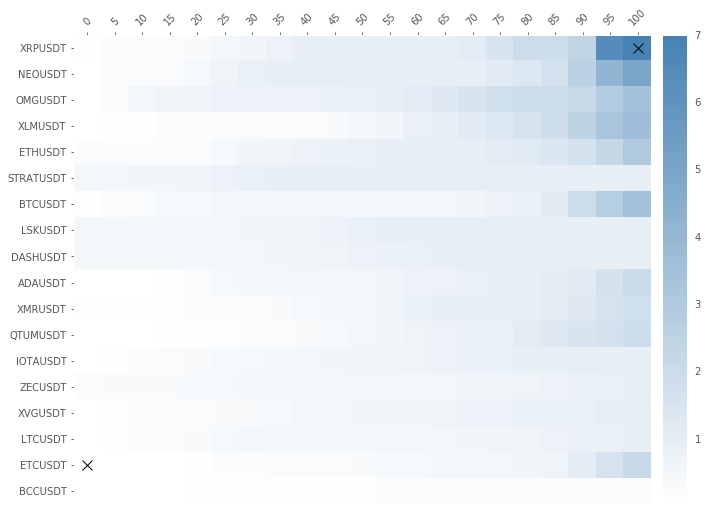

In [21]:
df = utils.to_df(stats.dd.details(ohlc), 'recovery_rate')
df = stats.dist.percentiles(df, 0, 100, 5).transpose()

idx_ranker = lambda sr: 1 / sr.sum()
cmap = cryptoz.plot.continuous_cmap(['white', 'steelblue'])
cryptoz.plot.heatmap(df, idx_ranker=idx_ranker, cmap=cmap)

# performance

   count      mean       std  min       25%       50%       75%  max
0  288.0  0.371884  0.308715  0.0  0.127454  0.279721  0.596682  1.0


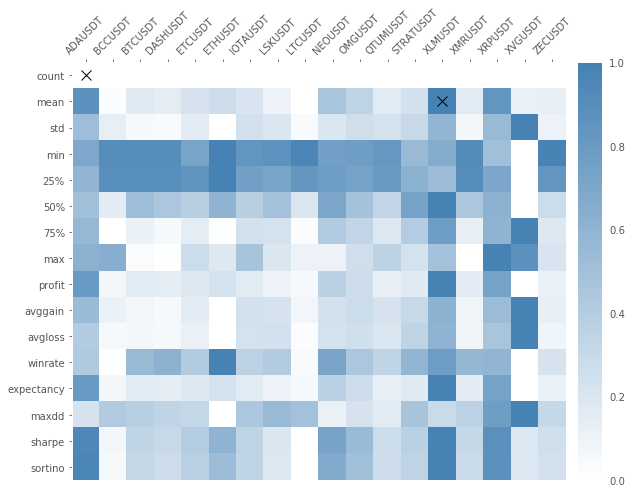

In [13]:
df = stats.perf.score_matrix(ohlc)

cmap = cryptoz.plot.continuous_cmap(['white', 'steelblue'])
cryptoz.plot.heatmap(df, cmap=cmap)

# correlation

   count      mean       std       min       25%       50%       75%  max
0  324.0  0.497278  0.200984  0.073636  0.344508  0.507804  0.614233  1.0


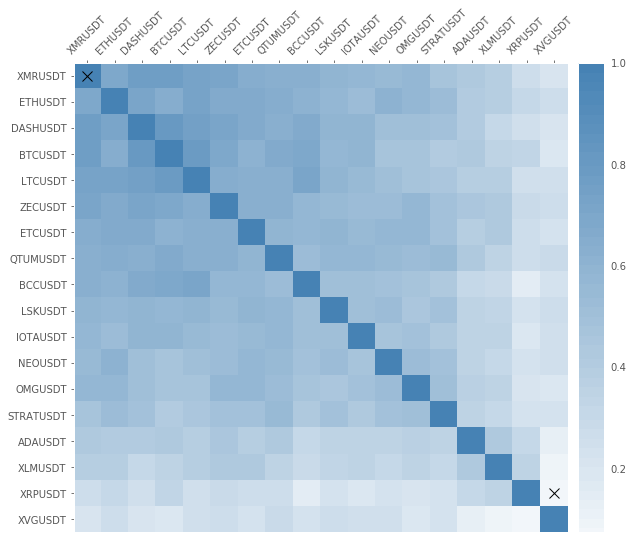

In [14]:
reload(cryptoz.plot)
df = stats.corr.apply(utils.to_df(ohlc, 'C').pct_change().dropna())

ranker = lambda sr: 1 / sr.sum()
cmap = cryptoz.plot.continuous_cmap(['orange', 'white', 'steelblue'])
norm = cryptoz.plot.midpoint_norm(0)
cryptoz.plot.heatmap(df, col_ranker=ranker, idx_ranker=ranker, cmap=cmap, norm=norm)

## rolling

   count     mean      std       min      25%       50%      75%       max
0  870.0  0.53858  0.36586 -0.572222  0.33582  0.624237  0.84437  0.966747


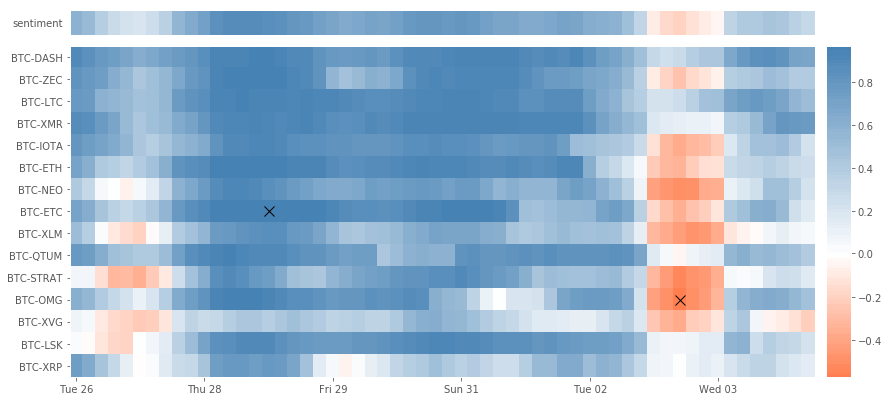

In [23]:
df = utils.to_df(ohlc, 'C').pct_change().dropna()
df = stats.corr.rolling(df, window=48)
regex = re.compile(r'(BTCUSDT-.+)')
df = df[list(filter(regex.search, df.columns))]
df.columns = list(map(lambda x: re.sub(r'(USDT)', '', x), df.columns))
df.dropna(inplace=True)

cmap = cryptoz.plot.continuous_cmap(['coral', 'white', 'steelblue'])
norm = cryptoz.plot.midpoint_norm(0)
cryptoz.plot.evolution(df.resample('4h').mean(), cmap=cmap, norm=norm)

# depth

    count          mean            std            min            25%  \
0  3600.0  24148.834209  312224.697905 -888477.146092 -152705.034446   

        50%            75%           max  
0  9.764935  170211.839456  1.987208e+06  


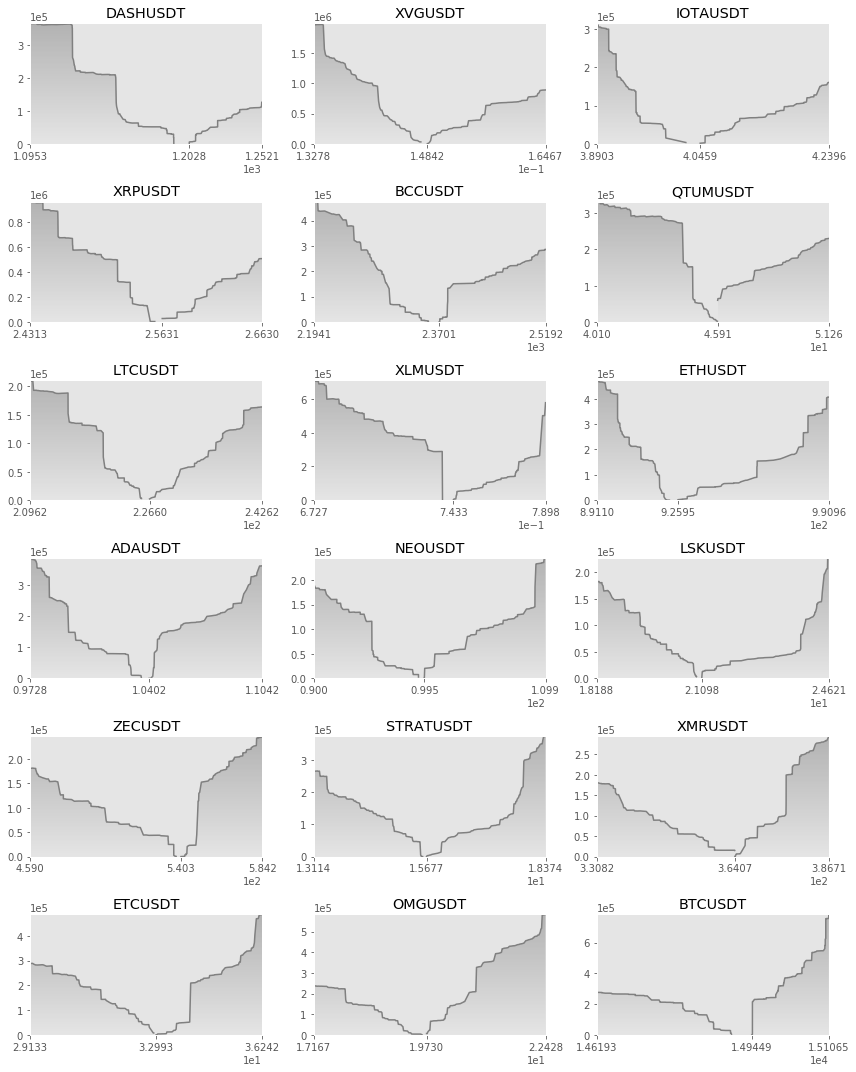

In [16]:
cryptoz.plot.depth(orderbooks, ranker=lambda sr: 1 - sr.max() / abs(sr.min()))

# score

## example: Bollinger Band

In [17]:
def rollmean(sr, window):
    return sr.rolling(window=window, min_periods=1).mean()

def rollstd(sr, window):
    return sr.rolling(window=window, min_periods=1).std()

def BollingerBand(sr, window, std_n):
    rollmean_sr = rollmean(sr, window)
    rollstd_sr = rollstd(sr, window)
    upper_band_sr = rollmean_sr + std_n * rollstd_sr
    lower_band_sr = rollmean_sr - std_n * rollstd_sr
    return upper_band_sr, lower_band_sr

def corridor(sr1, sr2):
    return sr1 - sr2

def normalize(sr):
    return (sr - sr.mean()) / sr.std()

### How wide is the BB?

   count      mean    std  min       25%       50%       75%  max
0  882.0  0.597709  0.382  0.0  0.225077  0.694743  0.989988  1.0


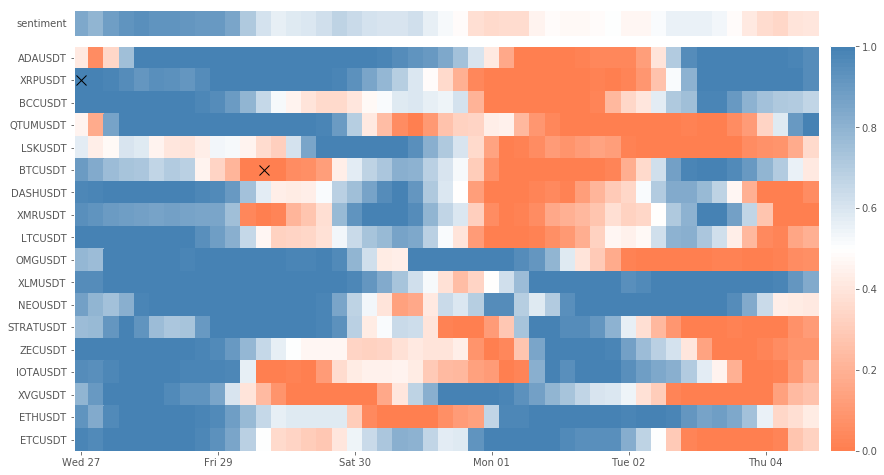

In [18]:
window = 120
std_n = 3

strategy = lambda ohlc_df: normalize(corridor(*BollingerBand(ohlc_df['C'], window, std_n)))
df1 = pd.DataFrame({pair: strategy(ohlc_df) for pair, ohlc_df in ohlc.items()})
score1_df = cryptoz.score.rolling_apply(df1, window=window, min_periods=window)
score1_df.dropna(inplace=True)

cmap = cryptoz.plot.continuous_cmap(['coral', 'white', 'steelblue'])
cryptoz.plot.evolution(score1_df.resample('4h').mean(), cmap=cmap)

### Is the price above the MA?

   count     mean       std  min       25%       50%       75%       max
0  882.0  0.51029  0.274332  0.0  0.270592  0.501164  0.763978  0.989506


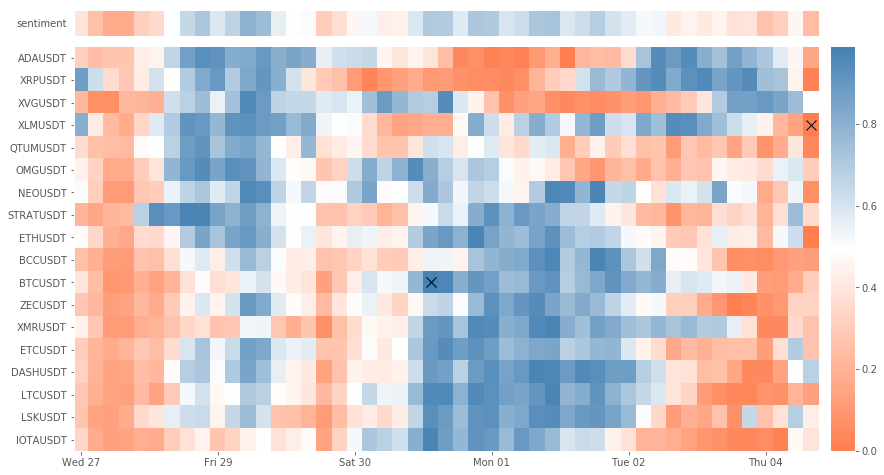

In [19]:
strategy = lambda ohlc_df: normalize(corridor(ohlc_df['C'], rollmean(ohlc_df['C'], window)))
df2 = pd.DataFrame({pair: strategy(ohlc_df) for pair, ohlc_df in ohlc.items()})
score2_df = cryptoz.score.rolling_apply(df2, window=window, min_periods=window)
score2_df.dropna(inplace=True)

cryptoz.plot.evolution(score2_df.resample('4h').mean(), cmap=cmap)

### When to buy/sell?

Rules
1. narrow corridor and price over MA -> trend up -> buy
2. wide corridor and price below MA -> oversold -> buy
3. narrow corridor and price below MA -> trend down -> sell
4. wide corridor and price above MA -> overbought -> sell

   count      mean       std       min       25%       50%       75%       max
0  882.0  0.405932  0.253561  0.006514  0.190052  0.362379  0.609626  0.966643


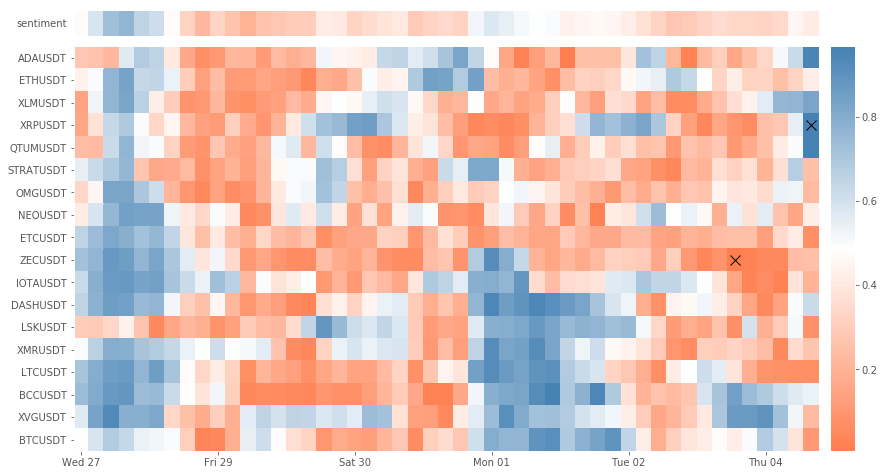

In [20]:
score_df = cryptoz.score.diff(score1_df, score2_df, axis=0) # axis 0: pair-local score
score_df.dropna(inplace=True)

cryptoz.plot.evolution(score_df.resample('4h').mean(), cmap=cmap)